In [ ]:
 pip install datasets transformers huggingface_hub

In [6]:
from datasets import load_dataset
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
from huggingface_hub import notebook_login
import numpy as np
import torch
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
from sklearn.metrics import f1_score
import seaborn as sn
from matplotlib import pyplot as plt

In [7]:
notebook_login()

In [8]:
dataset = load_dataset("HFFErica/topicclassificaition", data_files={'train': 'train.csv', 'test': 'test.csv'})
dataset

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


train.csv:   0%|          | 0.00/361k [00:00<?, ?B/s]

test.csv:   0%|          | 0.00/153k [00:00<?, ?B/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['Order', 'text', 'final_topic', 'topics', 'label'],
        num_rows: 2220
    })
    test: Dataset({
        features: ['Order', 'text', 'final_topic', 'topics', 'label'],
        num_rows: 952
    })
})

In [9]:
train_dataset = dataset['train']
test_dataset = dataset['test']

In [10]:
tokenizer = AutoTokenizer.from_pretrained('facebook/bart-large-mnli')
# Preprocess dataset
def preprocess_function(examples):
    return tokenizer(examples['text'], padding='max_length', truncation=True)

train_dataset = train_dataset.map(preprocess_function, batched=True)
test_dataset = test_dataset.map(preprocess_function, batched=True)

train_dataset.set_format(type='torch', columns=['input_ids', 'attention_mask', 'label'])
test_dataset.set_format(type='torch', columns=['input_ids', 'attention_mask', 'label'])


tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.15k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

Map:   0%|          | 0/2220 [00:00<?, ? examples/s]

Map:   0%|          | 0/952 [00:00<?, ? examples/s]

In [11]:
# Load model
num_labels = len(set(train_dataset['label']))
model = AutoModelForSequenceClassification.from_pretrained('facebook/bart-large', num_labels=num_labels)

config.json:   0%|          | 0.00/1.63k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/1.02G [00:00<?, ?B/s]

Some weights of BartForSequenceClassification were not initialized from the model checkpoint at facebook/bart-large and are newly initialized: ['classification_head.dense.bias', 'classification_head.dense.weight', 'classification_head.out_proj.bias', 'classification_head.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [12]:
def compute_metrics(eval_pred):
    logits, labels = eval_pred

    # Check if logits are in a tuple, and extract if needed
    if isinstance(logits, tuple):
        logits = logits[0]

    # Convert logits to a NumPy array if it's a PyTorch tensor
    if isinstance(logits, torch.Tensor):
        logits = logits.cpu().numpy()

    # Apply argmax to get predicted classes (axis=1 is used for NumPy arrays)
    predictions = np.argmax(logits, axis=-1)

    # Compute accuracy, precision, recall, and F1-score
    accuracy = accuracy_score(labels, predictions)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, predictions, average='micro')

    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1,
    }


In [13]:
# Define training arguments
training_args = TrainingArguments(
    output_dir="./zetoresults",
    eval_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=4,  # Use smaller batches
    gradient_accumulation_steps=4,  # Accumulate gradients over 4 steps (simulates batch_size = 4*4=16)
    num_train_epochs=3,
    weight_decay=0.01,
)

# Define trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)

# Train the model
trainer.train()

# Evaluate the model
eval_results = trainer.evaluate()
print(eval_results)

<ipython-input-13-c66f326b03d8>:13: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

 ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
0,No log,4.162108,0.129202,0.129202,0.129202,0.129202
1,No log,3.116589,0.342437,0.342437,0.342437,0.342437
2,No log,2.771572,0.426471,0.426471,0.426471,0.426471


/usr/local/lib/python3.10/dist-packages/transformers/configuration_utils.py:388: UserWarning: Some non-default generation parameters are set in the model config. These should go into either a) `model.generation_config` (as opposed to `model.config`); OR b) a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model).This warning will become an exception in the future.
Non-default generation parameters: {'early_stopping': True, 'num_beams': 4, 'no_repeat_ngram_size': 3, 'forced_bos_token_id': 0}
  warnings.warn(


{'eval_loss': 2.7715721130371094, 'eval_accuracy': 0.4264705882352941, 'eval_precision': 0.4264705882352941, 'eval_recall': 0.4264705882352941, 'eval_f1': 0.4264705882352941, 'eval_runtime': 118.877, 'eval_samples_per_second': 8.008, 'eval_steps_per_second': 1.001, 'epoch': 2.983783783783784}


In [14]:
# Save the model and tokenizer to a directory
model.save_pretrained("./fine_tuned_model")
tokenizer.save_pretrained("./fine_tuned_model")

/usr/local/lib/python3.10/dist-packages/transformers/configuration_utils.py:388: UserWarning: Some non-default generation parameters are set in the model config. These should go into either a) `model.generation_config` (as opposed to `model.config`); OR b) a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model).This warning will become an exception in the future.
Non-default generation parameters: {'early_stopping': True, 'num_beams': 4, 'no_repeat_ngram_size': 3, 'forced_bos_token_id': 0}
  warnings.warn(


('./fine_tuned_model/tokenizer_config.json',
 './fine_tuned_model/special_tokens_map.json',
 './fine_tuned_model/vocab.json',
 './fine_tuned_model/merges.txt',
 './fine_tuned_model/added_tokens.json',
 './fine_tuned_model/tokenizer.json')

In [15]:
# Load the saved model and tokenizer
model = AutoModelForSequenceClassification.from_pretrained("./fine_tuned_model")
tokenizer = AutoTokenizer.from_pretrained("./fine_tuned_model")

You passed along `num_labels=3` with an incompatible id to label map: {'0': 'LABEL_0', '1': 'LABEL_1', '2': 'LABEL_2', '3': 'LABEL_3', '4': 'LABEL_4', '5': 'LABEL_5', '6': 'LABEL_6', '7': 'LABEL_7', '8': 'LABEL_8', '9': 'LABEL_9', '10': 'LABEL_10', '11': 'LABEL_11', '12': 'LABEL_12', '13': 'LABEL_13', '14': 'LABEL_14', '15': 'LABEL_15', '16': 'LABEL_16', '17': 'LABEL_17', '18': 'LABEL_18', '19': 'LABEL_19', '20': 'LABEL_20', '21': 'LABEL_21', '22': 'LABEL_22', '23': 'LABEL_23', '24': 'LABEL_24', '25': 'LABEL_25', '26': 'LABEL_26', '27': 'LABEL_27', '28': 'LABEL_28', '29': 'LABEL_29', '30': 'LABEL_30', '31': 'LABEL_31', '32': 'LABEL_32', '33': 'LABEL_33', '34': 'LABEL_34', '35': 'LABEL_35', '36': 'LABEL_36', '37': 'LABEL_37', '38': 'LABEL_38', '39': 'LABEL_39', '40': 'LABEL_40', '41': 'LABEL_41', '42': 'LABEL_42', '43': 'LABEL_43', '44': 'LABEL_44', '45': 'LABEL_45', '46': 'LABEL_46', '47': 'LABEL_47', '48': 'LABEL_48', '49': 'LABEL_49', '50': 'LABEL_50', '51': 'LABEL_51', '52': 'LABEL_

In [17]:
label_mapping = {
1: "Accessibility options",
2: "Audio",
3: "BugsCrashing",
4: "Camera control",
5: "Cheating",
6: "Combat mechanics",
7: "Comparison",
8:"Competition",
9: "Content filter",
10: "Controls",
11: "Creative mechanics",
12: "Customisation",
13: "Developer",
14: "Development states",
15: "DifficultyBalance",
16: "Emotion",
17: "Engaging",
18:"Esports competition",
19: "Exploration",
20: "Game awareness duration",
21: "GameEvaluation",
22: "GameProgression",
23: "Graphics settings",
24: "Guide and Tutorials",
25: "ImmersionRealism",
26: "In-game economic mechanics",
27: "In-game physics mechanics",
28: "InteractionSocialisation",
29: "Language settings and Localisation",
30:"Launch",
31: "Learnability",
32: "Management mechanics",
33: "Mode settings",
34: "Movement mechanics",
35: "Narrative",
36: "Navigation and Maps",
37: "Novelty",
38: "OnlineVideo",
39: "Order state",
40: "Ownership",
41: "PersonalInfluence",
42: "Platforms",
43: "Players modification and Workshops",
44: "Playtime and Gameplay length",
45: "PriceQuality ratio",
46: "Promotion strategy and Marketing collateral",
47: "Puzzle mechanics",
48: "Recommendation",
49: "Refund",
50: "Returning player",
51:"Review experience",
52: "Review reception",
53:"Reward system",
54: "Server",
55:"Simulation mechanics",
56: "Social identity",
57: "Survival mechanics",
58: "UIandUX",
59: "Update",
60: "Virtual reality headset",
61: "VisualAtmosphere",
62:"Wishlist and Notifications"
}

In [18]:
import torch

# Example texts to classify
texts = [
    "They need the audio to be more random more audio files to randomly choose from so you get a more unique experience on every play through.",
    "unfortunately, some bugs like characters getting stuck permanently in a spot have also made a comeback lmao.",
    "I've had the game for a long time, and it was pretty fun for the first 30-50 hours",
    "Very cool story, which I had not expected. Exploration, ship fights, and base building is incredibly fun. Looking forward to Worlds Part 2 update.",
    "There is just so much to do in this big, beautiful game that you can just follow your whim and do what you want. ",
    "the planets are sometimes so good looking I hardly believe its procedural! "
]

# Tokenize the input text
inputs = tokenizer(texts, padding=True, truncation=True, return_tensors="pt")

# Make predictions (logits) using the model
with torch.no_grad():
    outputs = model(**inputs)

# Get predicted class (with argmax to select the highest scoring class)
predictions = torch.argmax(outputs.logits, dim=-1)

# Map predicted class indices to actual label names (assuming you know the label mapping)
predicted_labels_mapping = [label_mapping[pred.item()] for pred in predictions]
predicted_labels = [pred.item() for pred in predictions]

print(predicted_labels)
print(predicted_labels_mapping)

[2, 3, 44, 19, 19, 61]
['Audio', 'BugsCrashing', 'Playtime and Gameplay length', 'Exploration', 'Exploration', 'VisualAtmosphere']


In [19]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [20]:
import pandas as pd
data = pd.read_csv('/content/drive/My Drive/visual results/RepeatExperimentData/test.csv')
data['text']

,text
0,It is a universe filled with countless planets...
1,It's a fantastic game and I would recommend to...
2,Fighting on- and off planet is as exciting as ...
3,Everything is autopiloted- Feels more casual t...
4,Be patient and follow the storyline as
...,...
947,when a shooting actually occurs in a dance cl...
948,the same snarky humor and I can easily lose tr...
949,this is an awesome remake.
950,There's an ok amount of customization for the ...


In [21]:
def predict_topic(text):
    # Tokenize the input text
    inputs = tokenizer(text, padding=True, truncation=True, return_tensors="pt")

    # Make prediction using the model (with torch.no_grad to avoid computing gradients)
    with torch.no_grad():
        outputs = model(**inputs)

    # Get the predicted class (with argmax to select the highest scoring class)
    predicted_class = torch.argmax(outputs.logits, dim=-1).item()

    # Map the predicted class index to the label name
    predicted_label = label_mapping[predicted_class]

    return predicted_label

In [22]:
from tqdm import tqdm

tqdm.pandas()
data['predicted_label'] = data['text'].apply(predict_topic)
data.to_csv('/content/drive/My Drive/visual results/RepeatExperimentData/zero_predicted_labels_output_NF.csv', index=False)

In [23]:
print(data.head())

   Order                                               text  \
0      2  It is a universe filled with countless planets...   
1      3  It's a fantastic game and I would recommend to...   
2      4  Fighting on- and off planet is as exciting as ...   
3      4  Everything is autopiloted- Feels more casual t...   
4      6             Be patient and follow the storyline as   

            final_topic              topics  label           predicted_label  
0            Engaging_1            Engaging     17               Exploration  
1      Recommendation_5      Recommendation     48            Recommendation  
2    Combat mechanics_1    Combat mechanics      6  InteractionSocialisation  
3  Movement mechanics_4  Movement mechanics     34  InteractionSocialisation  
4           Narrative_4           Narrative     35                 Narrative  


# F1

In [24]:
rawdata = pd.read_csv('/content/drive/My Drive/visual results/RepeatExperimentData/zero_predicted_labels_output_NF.csv', encoding='utf-8')
rawdata

,Order,text,final_topic,topics,label,predicted_label
0,2,It is a universe filled with countless planets...,Engaging_1,Engaging,17,Exploration
1,3,It's a fantastic game and I would recommend to...,Recommendation_5,Recommendation,48,Recommendation
2,4,Fighting on- and off planet is as exciting as ...,Combat mechanics_1,Combat mechanics,6,InteractionSocialisation
3,4,Everything is autopiloted- Feels more casual t...,Movement mechanics_4,Movement mechanics,34,InteractionSocialisation
4,6,Be patient and follow the storyline as,Narrative_4,Narrative,35,Narrative
...,...,...,...,...,...,...
947,1792,when a shooting actually occurs in a dance cl...,ImmersionRealism_5,ImmersionRealism,25,ImmersionRealism
948,1793,the same snarky humor and I can easily lose tr...,Engaging_5,Engaging,17,Narrative
949,1794,this is an awesome remake.,GameEvaluation_5,GameEvaluation,21,GameEvaluation
950,1795,There's an ok amount of customization for the ...,Customisation_4,Customisation,12,Customisation


In [25]:
rawdata[rawdata['topics'] != rawdata['predicted_label']]

,Order,text,final_topic,topics,label,predicted_label
0,2,It is a universe filled with countless planets...,Engaging_1,Engaging,17,Exploration
2,4,Fighting on- and off planet is as exciting as ...,Combat mechanics_1,Combat mechanics,6,InteractionSocialisation
3,4,Everything is autopiloted- Feels more casual t...,Movement mechanics_4,Movement mechanics,34,InteractionSocialisation
6,7,but after about 2 hours of enjoying 5th or 6th...,BugsCrashing_2,BugsCrashing,3,InteractionSocialisation
7,8,The plants and animals often make no sense tog...,ImmersionRealism_1,ImmersionRealism,25,Exploration
...,...,...,...,...,...,...
942,1778,"From the voxel terrain editor, to the increasi...",Novelty_5,Novelty,37,VisualAtmosphere
943,1779,fun at start but repetitive somewhat mobile ga...,Engaging_2,Engaging,17,GameEvaluation
945,1787,and the trailers give you the impression that ...,Promotion strategy and Marketing collateral_2,Promotion strategy and Marketing collateral,46,GameEvaluation
948,1793,the same snarky humor and I can easily lose tr...,Engaging_5,Engaging,17,Narrative


In [26]:
y_actu = rawdata['topics']
y_pred = rawdata['predicted_label']

In [29]:
df_confusion = pd.crosstab(y_actu, y_pred, rownames=['Actual'], colnames=['Predicted'], margins=True)
df_confusion

Predicted,Audio,BugsCrashing,Combat mechanics,Comparison,Controls,Customisation,Developer,DifficultyBalance,Engaging,Exploration,...,Platforms,Players modification and Workshops,Playtime and Gameplay length,PriceQuality ratio,Recommendation,Refund,Update,Virtual reality headset,VisualAtmosphere,All
Actual,,,,,,,,,,,,,,,,,,,,,
Accessibility options,2,0,0,0,1,0,1,0,1,0,...,0,0,0,0,0,0,0,0,1,6
Audio,22,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,24
BugsCrashing,0,36,0,0,0,0,1,1,0,1,...,1,0,0,0,0,0,1,0,1,48
Camera control,1,0,0,0,1,0,0,0,0,1,...,0,0,0,0,0,0,0,0,1,4
Cheating,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Update,0,3,0,0,0,0,0,0,0,1,...,1,0,0,0,0,0,20,0,1,30
Virtual reality headset,0,1,0,0,1,0,0,0,0,0,...,1,0,0,0,0,0,0,5,1,9
VisualAtmosphere,0,1,0,1,0,0,0,0,0,8,...,0,0,0,0,0,0,0,0,37,51


In [30]:
df_confusion =df_confusion[:62]
df_confusion= df_confusion.drop('All', axis=1)
df_confusion

Predicted,Audio,BugsCrashing,Combat mechanics,Comparison,Controls,Customisation,Developer,DifficultyBalance,Engaging,Exploration,...,Narrative,Platforms,Players modification and Workshops,Playtime and Gameplay length,PriceQuality ratio,Recommendation,Refund,Update,Virtual reality headset,VisualAtmosphere
Actual,,,,,,,,,,,,,,,,,,,,,
Accessibility options,2,0,0,0,1,0,1,0,1,0,...,0,0,0,0,0,0,0,0,0,1
Audio,22,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
BugsCrashing,0,36,0,0,0,0,1,1,0,1,...,0,1,0,0,0,0,0,1,0,1
Camera control,1,0,0,0,1,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,1
Cheating,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
UIandUX,0,2,0,1,6,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,2
Update,0,3,0,0,0,0,0,0,0,1,...,0,1,0,0,0,0,0,20,0,1
Virtual reality headset,0,1,0,0,1,0,0,0,0,0,...,0,1,0,0,0,0,0,0,5,1


In [31]:
y_true = []
y_pred = []
for actual_class in df_confusion.index:
    for predicted_class in df_confusion.columns:
        count = df_confusion.loc[actual_class, predicted_class]
        y_true.extend([actual_class] * count)
        y_pred.extend([predicted_class] * count)

f1 = f1_score(y_true, y_pred, average='macro')
print("F1 Score (Macro):", f1)

F1 Score (Macro): 0.20141208338522076


In [32]:
f1 = f1_score(y_true, y_pred, average='micro')
print("F1 Score (Micro):", f1)

F1 Score (Micro): 0.4264705882352941


In [33]:
df_confusion.to_csv('/content/drive/My Drive/visual results/RepeatExperimentData/zero_test_predict_replaced_confusion_NF.csv')

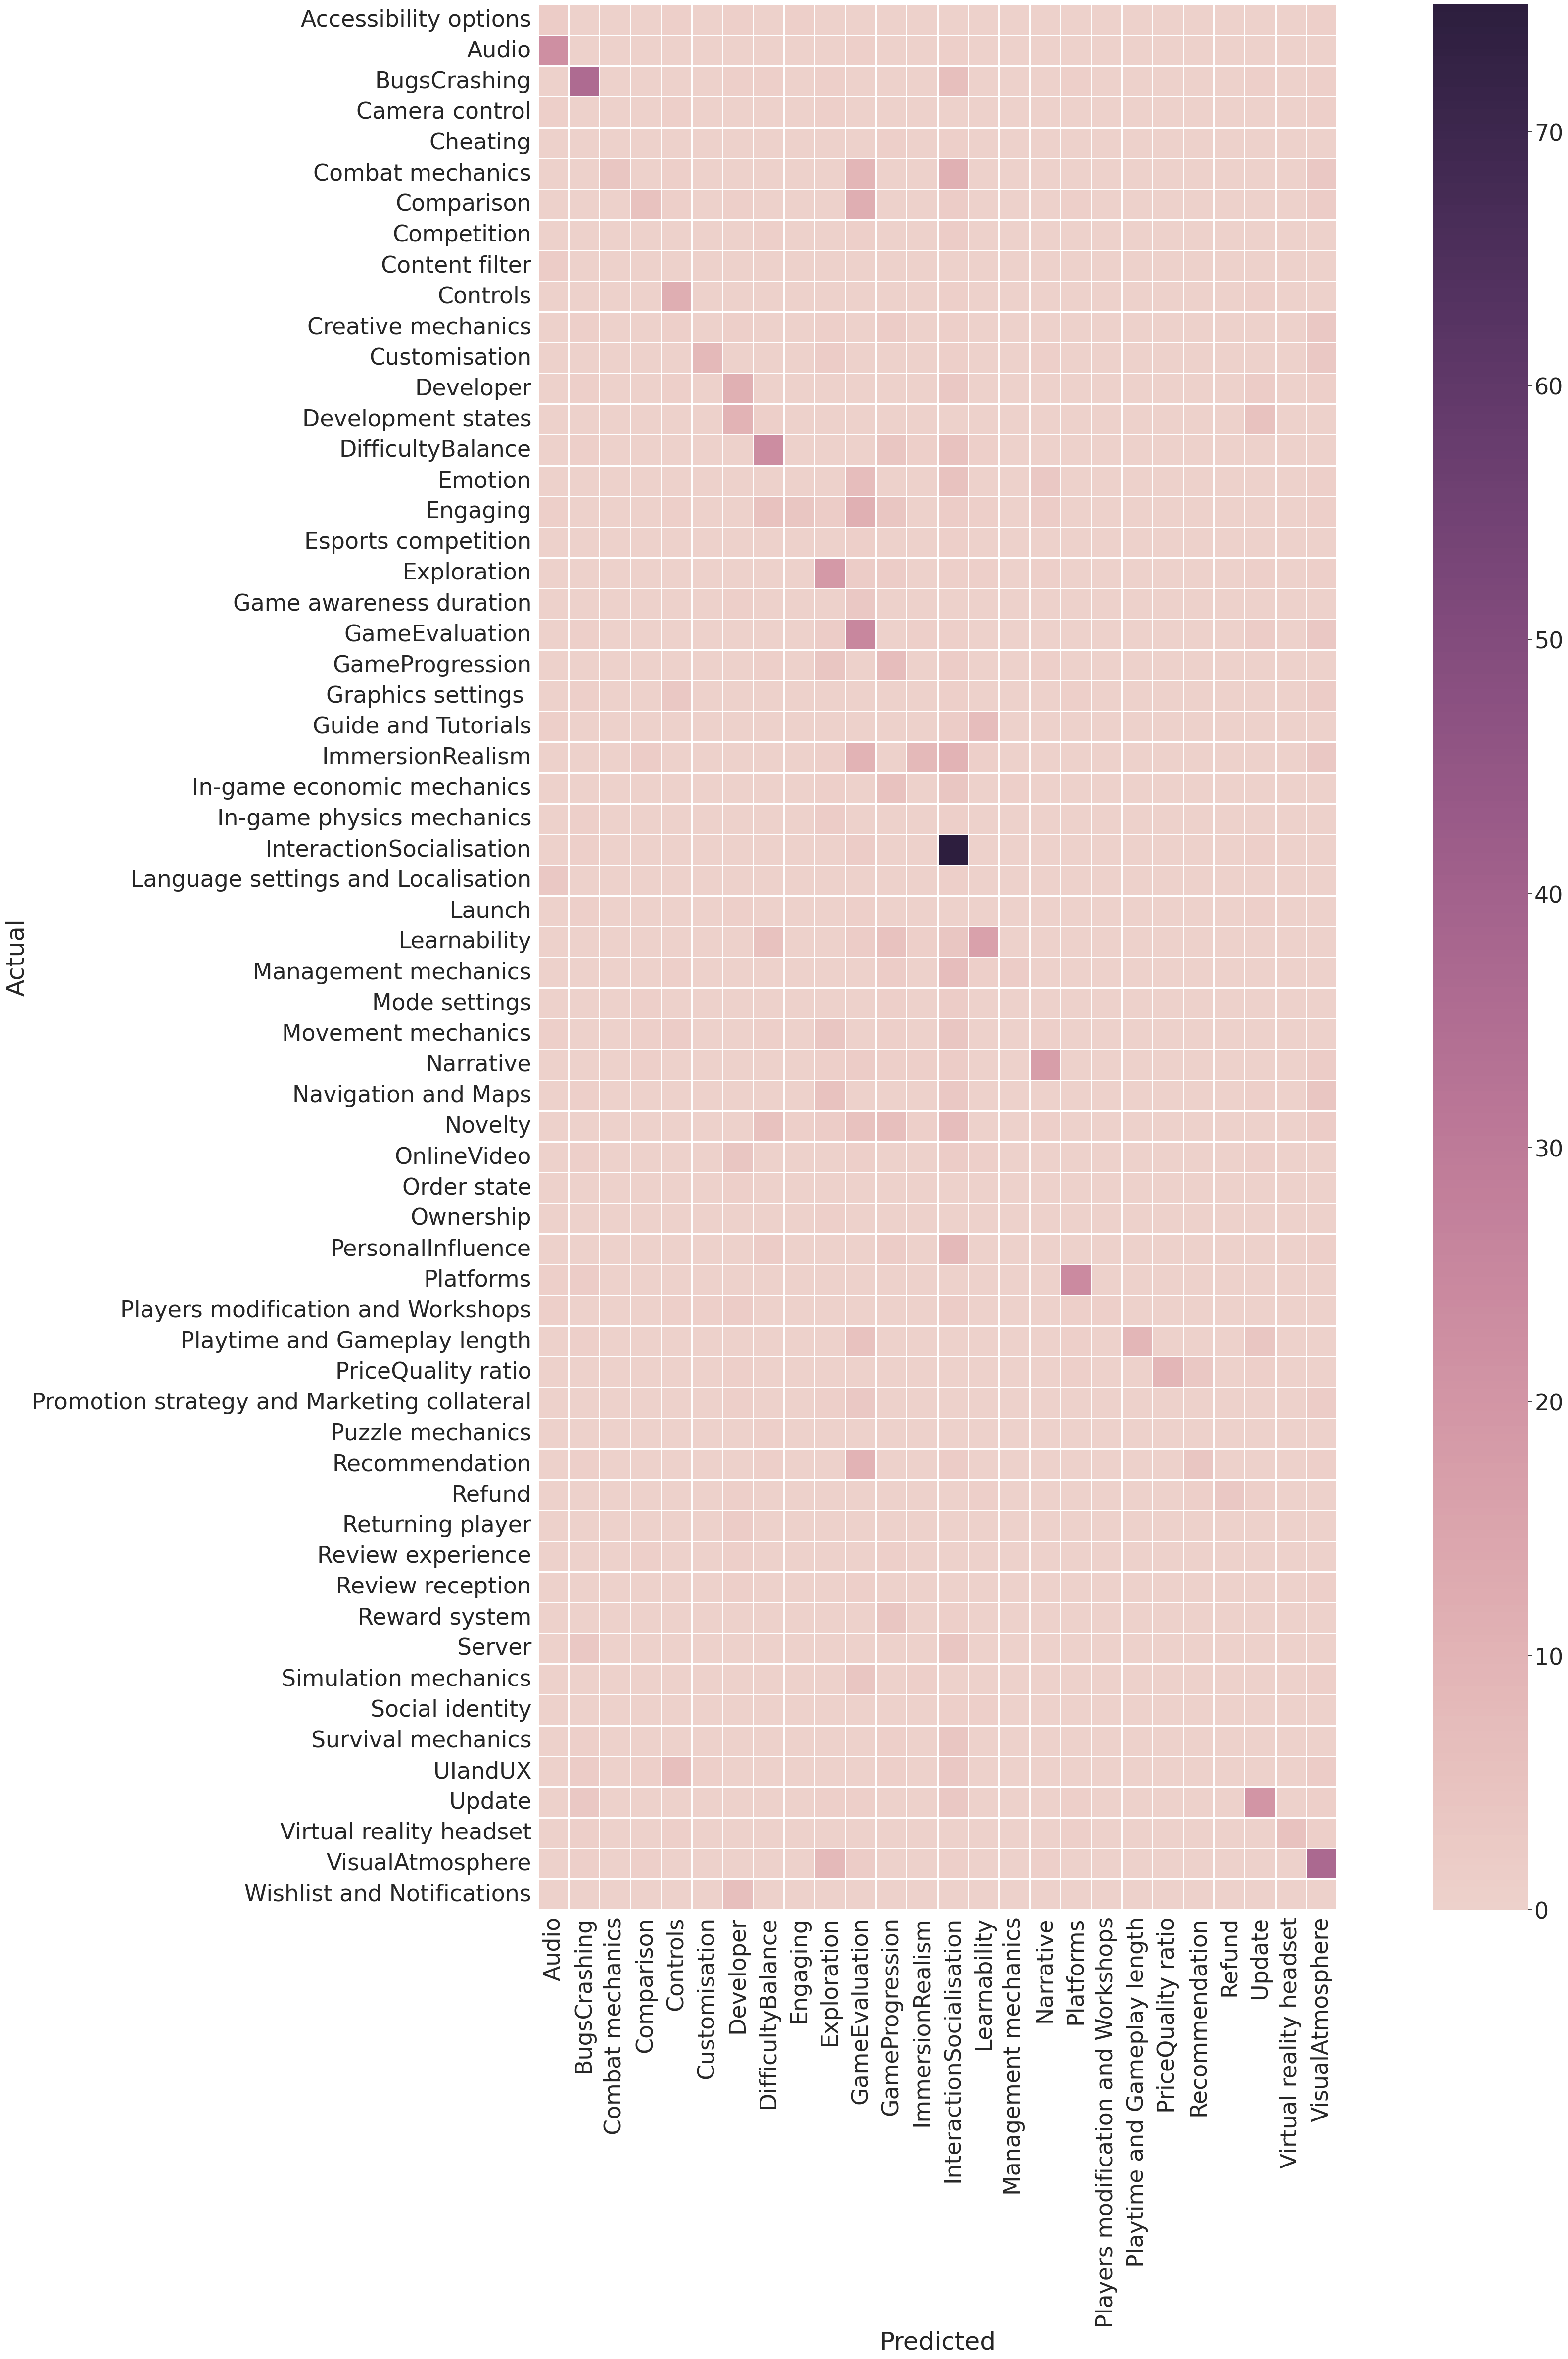

In [34]:
plt.figure(figsize = (50,50))

sn.set(font_scale=3) # for label size
sn.heatmap(df_confusion,  annot_kws={"size": 22}, cmap=sn.cubehelix_palette(as_cmap=True), fmt=".2f", square=True, linewidths=1, linecolor = "white")

plt.show()

In [35]:
from sklearn.preprocessing import minmax_scale
df_confusion[:] = minmax_scale(df_confusion)

<ipython-input-35-3a736708d99a>:2: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[0.09090909 1.         0.         0.04545455 0.         0.
 0.         0.         0.09090909 0.         0.         0.
 0.         0.         0.         0.         0.04545455 0.
 0.         0.         0.         0.         0.         0.04545455
 0.         0.         0.         0.         0.13636364 0.
 0.         0.         0.         0.04545455 0.         0.
 0.         0.         0.         0.         0.         0.04545455
 0.04545455 0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.        ]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_confusion[:] = minmax_scale(df_confusion)
<ipython-input-35-3a736708d99a>:2: FutureWarning: Setting an item of incompatible 

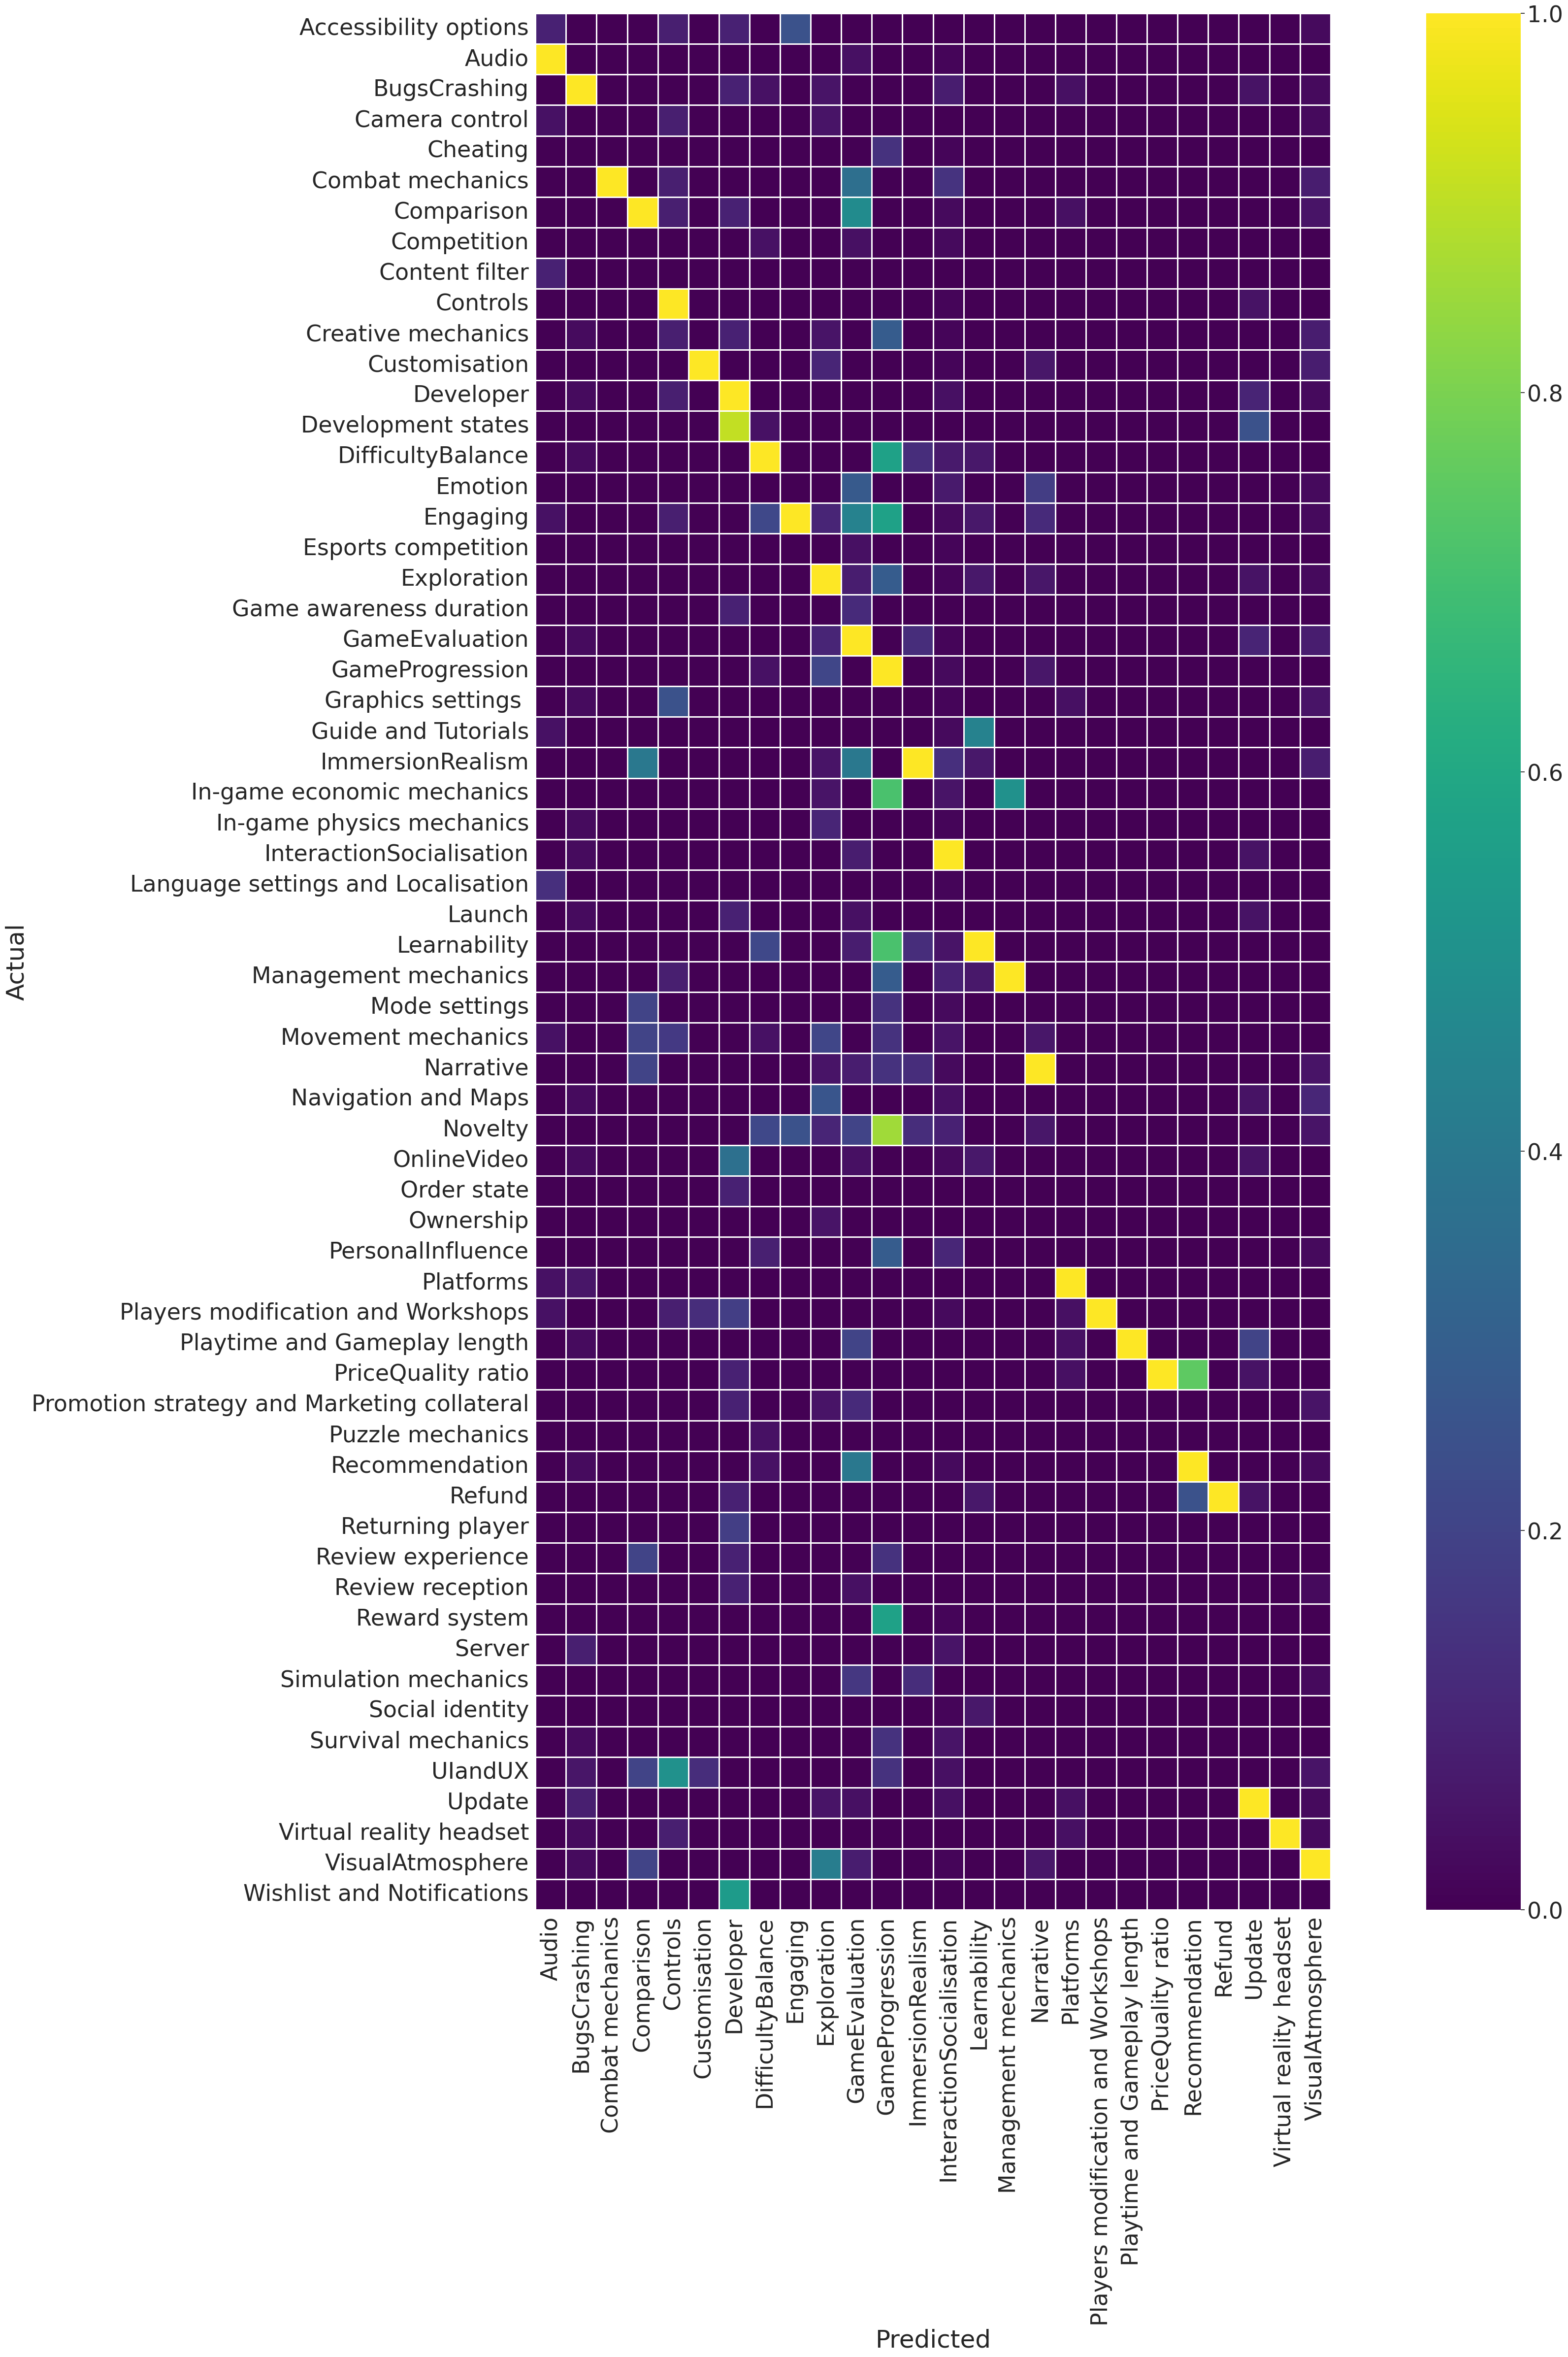

In [36]:
plt.figure(figsize = (50,50))

sn.set(font_scale=3) # for label size
sn.heatmap(df_confusion,  annot_kws={"size": 22}, cmap="viridis", fmt=".2f", square=True, linewidths=1, linecolor = "white")

plt.show()